<a href="https://colab.research.google.com/github/TranTan1410/tuan13/blob/main/Facial_Keypoints_Detection_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import seaborn as sns
import pandas as pd
from skimage.transform import resize
from skimage.io import imread
import os
import time
import tensorflow.keras.layers as l
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Utility plot function
def showKeypoints(img,kps,pred=None):
    plt.imshow(img)
    kps = np.reshape(kps,(-1,2))
    kps = kps*50 +100
    if pred is not None:
      pred = np.reshape(pred,(-1,2))
      pred = pred*50 +100
      plt.scatter(kps[27:36,0],kps[27:36,1],s=4,c='red',label="ground truth")
      plt.scatter(pred[27:36,0],pred[27:36,1],s=4,c='blue',label="prediction")
      
    else:

      plt.scatter(kps[27:36,0],kps[27:36,1],s=10,c='red',label="ground truth")
    
   

In [ ]:
# keras custom dataGenerator

class DataGen:
    def __init__(self,csv,dir_,target_size,batch_size,split=None):
        self.csv = csv
        self.dir = dir_
        self.df = pd.read_csv(self.csv)
        self.batch =batch_size
        self.target_size = target_size
        if split is not None:
            if len(split)==2:
                self.images = np.array(self.df.iloc[split[0]:split[1],0])
                self.kps = np.array(self.df.iloc[split[0]:split[1],1:])
            else:
                self.images = np.array(self.df.iloc[split[0]:,0])
                self.kps = np.array(self.df.iloc[split[0]:,1:])
        else:
            self.images = np.array(self.df.iloc[:,0]) 
            self.kps = np.array(self.df.iloc[:,1:])
        self.length = self.images.shape[0]
    
    def __len__(self):
        
        return len(self.images)
    # rescaling image to 146 x 146    
    def rescale(self,sample):
        
        size = self.target_size[0]+50,self.target_size[1]+50
        img = sample["img"]
        kps = sample["kps"]
        
        h,w = img.shape[:2]
        if isinstance(size, int):
            if h > w:
                new_h, new_w = size * h / w, size
            else:
                new_h, new_w = size, size * w / h
        else:
            new_h,new_w = size
        new_h,new_w = int(new_h),int(new_w)
        new_im = resize(img,size)
        new_kps = kps * [new_w / w, new_h / h]
        
        return {"img": new_im,"kps":new_kps}
    
    # applying random crop to final size 96 x 96
    def random_crop(self,sample):
        
        h,w = self.target_size
        image, key_pts = sample['img'], sample['kps']

        im_h, im_w = image.shape[:2]
        

        top = np.random.randint(0,im_h - h)
        left = np.random.randint(0, im_w - w)

        image = image[top: top + h,
                      left: left + w]

        key_pts = key_pts - [left, top]

        return {'img': image, 'kps': key_pts}
    
    # Image Normalization
    def normalize(self, sample):
        image, key_pts = sample['img'], sample['kps']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        
        
        # scale color range from [0, 255] to [0, 1]
        red,green,blue = np.max(image_copy[:,:,0]),np.max(image_copy[:,:,1]),np.max(image_copy[:,:,2])
        image_copy[:,:,0] = image_copy[:,:,0]/red
        image_copy[:,:,1] = image_copy[:,:,1]/green
        image_copy[:,:,2] = image_copy[:,:,2]/blue    
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'img': image_copy, 'kps': key_pts_copy}
        
        

    def generate(self):
        
        while True:
            batch_images=[]
            batch_keypoints=[]
            for i in range(self.batch):
                idx = np.random.randint(self.length)
            
                img_name = self.images[idx]
                
                # image pipeline
                img = imread(self.dir+img_name)
                # eliminating alpha channel
                img = img[:,:,:3]
                
                # reshaping the keypoints
                key_points = self.kps[idx]
                key_points = key_points.astype('float').reshape(-1, 2)
                sample = {"img": img, "kps": key_points}
                
                # rescaling the image
                sample = self.rescale(sample)
                
                # random_cropping
                sample = self.random_crop(sample)
                   
                # normalization    
                sample = self.normalize(sample)
                img = sample["img"]
                kps = np.reshape(sample["kps"],(136,))
                batch_images.append(img)
                batch_keypoints.append(kps)
            
            # ready batch after pipeline
            batch_images = np.array(batch_images)
            batch_keypoints = np.array(batch_keypoints)
            
            
            
            yield batch_images,batch_keypoints

In [ ]:
test = DataGen("/content/drive/MyDrive/data/data/test.csv","/content/drive/MyDrive/data/data/test/",(96,96),8) # Test Generator
train = DataGen("/content/drive/MyDrive/data/data/training.csv","/content/drive/MyDrive/data/data/training/",(96,96),64,split=[0,2600]) # Training Generator
validation = DataGen("/content/drive/MyDrive/data/data/training.csv","/content/drive/MyDrive/data/data/training/",(96,96),8,split=[2600])

In [ ]:
print(f"Training dataset :{len(train)} images")
print(f"Validation dataset :{len(validation)} images")
print(f"Test dataset :{len(test)} images")

Training dataset :2600 images
Validation dataset :862 images
Test dataset :770 images


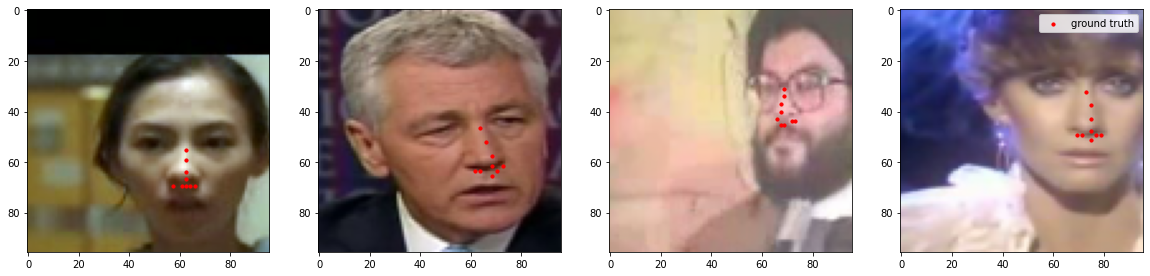

In [ ]:
t = validation.generate()
plt.figure(figsize=(20,30))
im,keyp = next(t)
for i in range(4):
  plt.subplot( 1,4,i+1)
  #print(im[i][:,:,:].shape)
  showKeypoints(im[i][:,:,:],keyp[i])
plt.legend()
plt.show()

In [ ]:
validation_loss =[]
class Validation(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        score = model.evaluate_generator(validation.generate(),100)
        validation_loss.append(score)
        print("Validation_loss : ",score)
    

In [ ]:
model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(32,(5,5),input_shape=(96,96,3),data_format="channels_last"),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPool2D((2,2),2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),         # Dropout
    tf.keras.layers.Conv2D(64,(3,3)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPool2D((2,2),2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),         # Dropout
    tf.keras.layers.Conv2D(128,(3,3)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPool2D((2,2),2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),         # Dropout   
    tf.keras.layers.Conv2D(256,(3,3)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPool2D((2,2),2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),         # Dropout 
    tf.keras.layers.Conv2D(512,(1,1)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPool2D((2,2),2),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(1024),
    tf.keras.layers.ELU(),    
    tf.keras.layers.Dropout(0.5), # Dropout 
    tf.keras.layers.Dense(1024),
    tf.keras.layers.ELU(),  
    tf.keras.layers.Dense(136,activation="linear")])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 92, 92, 32)        2432      
                                                                 
 elu_14 (ELU)                (None, 92, 92, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 46, 46, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 46, 46, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 46, 46, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 44, 44, 64)       

In [ ]:
#model = tf.keras.models.load_model("checkpoint1.pt")

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model.compile(optimizer =opt,loss="mean_squared_error")

In [ ]:
t = train.generate()
n_samples = len(train)
steps_per_epoch = n_samples//64

In [ ]:
# Training !

history = model.fit(t,epochs=10,steps_per_epoch=steps_per_epoch,callbacks=[Validation()])

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 0.8652

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """


Validation_loss :  0.4517684876918793
40/40 [==============================] - 280s 7s/step - loss: 0.8652
Epoch 2/10
40/40 [==============================] - 275s 7s/step - loss: 0.2672
Epoch 3/10
40/40 [==============================] - 277s 7s/step - loss: 0.1528
Epoch 4/10
40/40 [==============================] - 275s 7s/step - loss: 0.1199
Epoch 5/10
40/40 [==============================] - 280s 7s/step - loss: 0.0889
Epoch 6/10
40/40 [==============================] - 274s 7s/step - loss: 0.0689
Epoch 7/10
40/40 [==============================] - 276s 7s/step - loss: 0.0536
Epoch 8/10
40/40 [==============================] - 277s 7s/step - loss: 0.0488
Epoch 9/10
40/40 [==============================] - 280s 7s/step - loss: 0.0436
Epoch 10/10
40/40 [==============================] - 274s 7s/step - loss: 0.0402


In [ ]:
loss_history= history.history["loss"] # training loss history


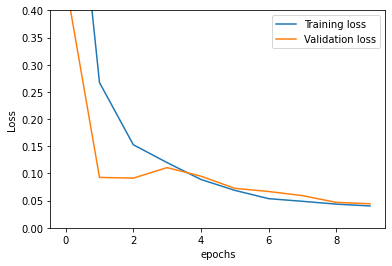

In [ ]:

sns.lineplot(data=loss_history,label="Training loss")
sns.lineplot(data=validation_loss[-40:],label="Validation loss")
plt.title("")
plt.xlabel("epochs")
plt.ylabel("Loss")

plt.ylim(0, 0.4)
plt.show()

In [ ]:
# Testing 
t = test.generate()

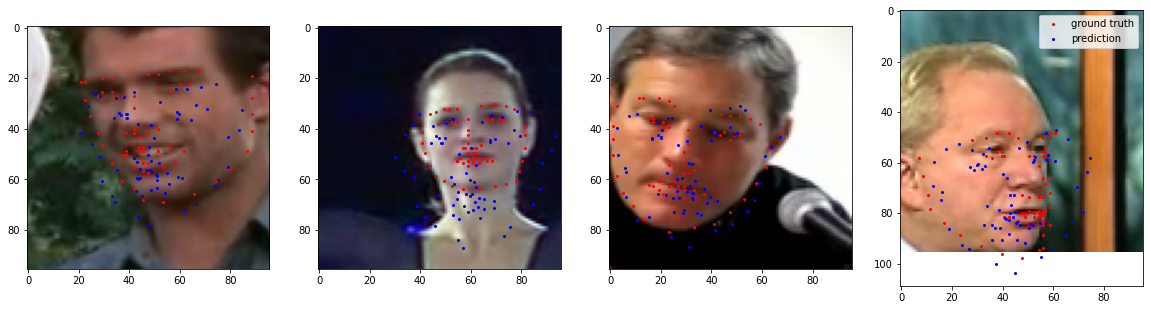

In [ ]:

im,keyp = next(t)
plt.figure(figsize=(20,30))
pred = model.predict(im)
for i in range(4):
  plt.subplot( 1,4,i + 1)

  
  showKeypoints(im[i][:,:,:],keyp[i],pred=pred[i])

plt.legend()
plt.show()

In [ ]:
model.save("checkpoint1.pt")

INFO:tensorflow:Assets written to: checkpoint1.pt/assets


In [ ]:
import cv2
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


fr = cv2.imread('michael jackson.jpg')		
fr = cv2.cvtColor(fr,cv2.COLOR_BGR2RGB)
im = fr.copy()
H,W,C = fr.shape
#im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(im, 1.3, 5)
for (x,y,w,h) in faces:

    fr = cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)
    roi = im[y:y+h, x:x+w]
			
    roi = resize(roi,(96,96))
			
    roi = roi[:,:,:3]
#     roi[:,:,0] = roi[:,:,0]/255.0
#     roi[:,:,1] = roi[:,:,1]/255.0
#     roi[:,:,2] = roi[:,:,2]/255.0

    H,W,C = roi.shape
    roi = np.expand_dims(roi,0)
    #roi_gray = np.expand_dims(roi_gray,3)
		
    res = model.predict(roi)
		
    res = res*50+100
    res = np.reshape(res,(-1,2))
    res = res*[(w)/96,(h)/96]
    res = res+[x,y]
			
    for i in res:
        u,v = int(i[0]),int(i[1])
        cv2.circle(fr,(u,v),4,(255,255,255),-1)
plt.imshow(fr)
plt.show()

In [ ]:
score = model.evaluate_generator(test.generate(),steps=50,verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


50/50 [==============================] - 25s 510ms/step - loss: 0.0388


In [ ]:
#Average test loss
print(f"Test loss : {score}")

Test loss : 0.03882791846990585
